In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import torch
import torchvision
# from torchdata.datapipes.iter import IterableWrapper, Mapper
import os
from skimage.io import imread
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [4]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")

Good to go!


In [5]:
def convert_img(im):
    if len(im.shape)==4:
        img=im[0]
    else:
        img=im
    img=torch.stack([img[0],img[1],img[2]],axis=-1)
    img=np.array(img)
    return img

In [6]:
train_dir='buildings/train'
valid_dir='buildings/test'

In [11]:
datapoint=imread('buildings/train/000_4.png')

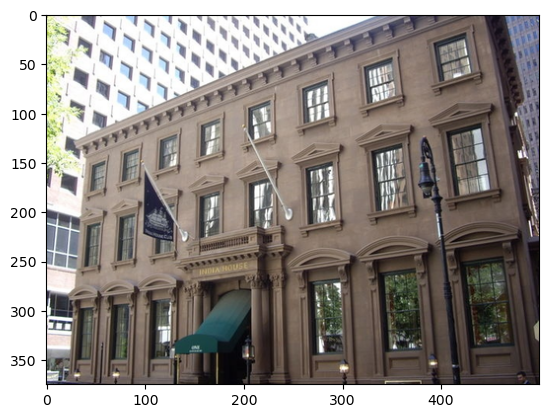

In [12]:
datapoint.shape
plt.imshow(datapoint)

## Build DataLoader

In [13]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):

        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        output_size=self.output_size
        h, w = image.shape[:2]
        
        end_h=h-output_size
        end_w=w-output_size
    
        h_s=np.random.randint(0,end_h)
        w_s=np.random.randint(0,end_w)
    
        h_e=h_s+output_size
        w_e=w_s+output_size
#         new_h, new_w = self.output_size

#         top = np.random.randint(0, h - new_h + 1)
#         left = np.random.randint(0, w - new_w + 1)

#         image = image[top: top + new_h,
#                       left: left + new_w]

#         landmarks = landmarks - [left, top]
        image=image[h_s:h_e,w_s:w_e,:]
        landmarks=landmarks[h_s:h_e,w_s:w_e,:]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        landmarks=landmarks.transpose((2,0,1))
        
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

class ToBlur(object):
    def __init__(self,kernel_size):
        self.kernel_size=kernel_size
    def __call__(self,sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        image=torchvision.transforms.functional.gaussian_blur(image,kernel_size=self.kernel_size,sigma=(0.1,1.5))
        
        
        return {'image': image,
                'landmarks': landmarks}

class SubUp(object):
    def __init__(self,factor):
        self.factor=factor
    def __call__(self,sample):
        image, landmarks = sample['image'], sample['landmarks']
        size=landmarks.shape[1:]
        factor=self.factor
        image=image[:,::factor,::factor]
        
        #comment out three lines below to use original low_quality image without upsampling
        upsample=torchvision.transforms.Resize(size, interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
        image=upsample.forward(image)
        imgage=torch.clamp(image,min=0,max=1)
                
        return {'image': image,
                'landmarks':landmarks}                                                              

In [69]:
class Dataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        paths=os.listdir(root_dir)
        self.paths = paths*30
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.paths[idx])
        image = plt.imread(img_name)
        landmarks = plt.imread(img_name)
 
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [70]:
transformer=transforms.Compose([ RandomCrop(54),
                                ToTensor(),
                                ToBlur(3),
                                SubUp(factor=2)
                                       ])

In [71]:
transformed_dataset = Dataset( root_dir=train_dir,
                                transform=transformer)
transformed_testset = Dataset( root_dir=valid_dir,
                                transform=transformer)


In [73]:
training_loader = DataLoader(transformed_dataset, batch_size=128,
                        shuffle=True, num_workers=0)
validation_loader = DataLoader(transformed_testset, batch_size=16,
                        shuffle=True, num_workers=0)

In [18]:
#TEST THE DATALOADER TO CHECK THAT EVERYTHING IS RIGHT
data_iter=iter(validation_loader)
data_iter_item=next(data_iter)
print("input shape:", data_iter_item['image'].size())
print("label shape:", data_iter_item['landmarks'].size())

C:\Users\NET-BCH\miniconda3\envs\pytorch\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


input shape: torch.Size([16, 3, 54, 54])
label shape: torch.Size([16, 3, 54, 54])


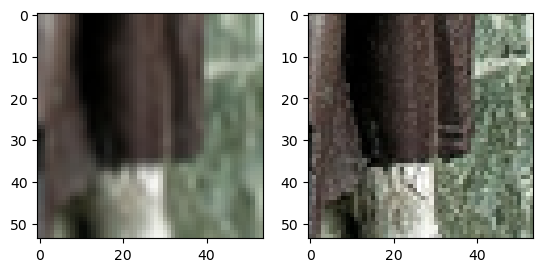

In [19]:
# for i_batch, sample_batched in enumerate(training_loader):
#     print(sample_batched['image'].size())
img=convert_img(data_iter_item['image'][3])
label=convert_img(data_iter_item['landmarks'][3])
plt.subplot(1,2,1)
plt.imshow(img)

plt.subplot(1,2,2)
plt.imshow(label)

## Build the model

In [20]:
import torch.nn.functional as F
import torch.nn as nn

In [25]:
# PyTorch models inherit from torch.nn.Module
class SuperReso(nn.Module):
    def __init__(self):
        super(SuperReso, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 11,padding=1)
        self.batchnorm1=nn.BatchNorm2d(128)
        #self.pool = nn.MaxPool2d(2, 2).to()
        self.conv2 = nn.Conv2d(128,64 ,3,padding=1)
        self.batchnorm2=nn.BatchNorm2d(64)
        
        self.conv3=nn.Conv2d(64,3,5)
        
#         self.conv4=nn.Conv2d(32,3,3)
        # self.fc1 = nn.Linear(16 * 4 * 4, 120)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = x.view(-1, 16 * 4 * 4)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        x=self.conv1(x)
        x=F.leaky_relu(self.batchnorm1(x),negative_slope=0.2)
        x=self.conv2(x)
        x=F.leaky_relu(self.batchnorm2(x),negative_slope=0.2)
        x=self.conv3(x)
        return x

In [26]:
def init_weights(module):
    if isinstance(module, nn.Conv2d):
        module.weight.data.normal_(mean=0.0, std=0.001)
        if module.bias is not None:
            module.bias.data.zero_()

In [27]:
model=SuperReso()
# model.load_state_dict(torch.load('/kaggle/input/sr-model/best_model1115_100.pt'))
model.apply(init_weights)
model.to(DEVICE)

SuperReso(
  (conv1): Conv2d(3, 128, kernel_size=(11, 11), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1))
)

In [28]:
# TEST THE SHAPE OF THE OUTPUT IMAGE
dummy=torch.rand(2,3,54,54).to(DEVICE)
dummy_out=model(dummy)
dummy_out.shape

torch.Size([2, 3, 42, 42])

## Customized loss

In [29]:
def customized_loss(outputs,labels):
    out_size=outputs.shape[-1]
    
    crop_func=torchvision.transforms.CenterCrop(out_size)
    labels=crop_func.forward(labels)
    loss_fn = torch.nn.MSELoss()
    loss = loss_fn(outputs, labels)
    return loss

## Customize learning rate

In [30]:
from torch.optim import Adam

In [31]:
# Optimizers specified in the torch.optim package

optimizer = Adam(
    [
        {"params": model.conv1.parameters(), "lr": 1e-4},
        {"params":model.batchnorm1.parameters(),"lr":1e-5},
        {"params": model.conv2.parameters(),"lr":1e-4},
        {"params":model.batchnorm2.parameters(),"lr":1e-5},
        
        # {"params": model.conv4.parameters(),"lr":1e-4},
        # {"params": model.conv5.parameters(),"lr":1e-4},
        # {"params": model.conv6.parameters(),"lr":1e-4},
        {"params": model.conv3.parameters(),"lr":1e-5},
    ],
    lr=5e-5,
)

In [32]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs= data['image'].to(DEVICE)
        
        labels=data['landmarks'].to(DEVICE)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        
        # Compute the loss and its gradients
        loss = customized_loss(outputs, labels)
        print("loss: ",loss)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
     
        if i % 165 == 164:
            last_loss = running_loss / 165 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
#             tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [55]:
from datetime import datetime
# from torch.utils.tensorboard import SummaryWriter

In [81]:
model=SuperReso()
model.load_state_dict(torch.load('model1135/model1135_80.pt'))
model.to(DEVICE)

SuperReso(
  (conv1): Conv2d(3, 128, kernel_size=(11, 11), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1))
)

In [82]:
# Initializing in a separate cell so we can easily add more epochs to the same run
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/super_resolution_trainer_{}'.format(timestamp))
epoch_number = 80

EPOCHS = 80+20
# writer = SummaryWriter('runs/super_resolution_trainer_model1135_comp_{}'.format(timestamp))
best_vloss = 1000

for epoch in range(epoch_number,EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs=vdata['image'].to(DEVICE)
            vlabels=vdata['landmarks'].to(DEVICE)
            voutputs = model(vinputs)
            vloss = customized_loss(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # # Log the running loss averaged per batch
    # for both training and validation
#     writer.add_scalars('Training vs. Validation Loss',
#                     { 'Training' : avg_loss, 'Validation' : avg_vloss },
#                     epoch_number + 1)
#     writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        print("kim")
        best_vloss = avg_vloss

        model_path = 'model1135/model1135_{}.pt'.format(epoch_number+1)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 81:
loss:  tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward0>)
loss:  tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward0>)
loss:  tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward0>)
loss:  tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward0>)
loss:  tensor(0.0059, device='cuda:0', grad_fn=<MseLossBackward0>)
loss:  tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward0>)
loss:  tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward0>)
loss:  tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward0>)
loss:  tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward0>)
loss:  tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward0>)
loss:  tensor(0.0058, device='cuda:0', grad_fn=<MseLossBackward0>)
loss:  tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward0>)
loss:  tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward0>)
loss:  tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward0>)
loss:  tensor(0.0035, device='cuda:0', grad_fn=<MseL

## Visualize result

In [83]:
torch.save(model.state_dict(),'model1135/model1135_100.pt')

In [100]:
model = SuperReso() # initialize your model class
model.load_state_dict(torch.load('model1135/model1135_95.pt'))

<All keys matched successfully>

In [101]:
test_data=Dataset(root_dir='beau/SR_testing_datasets/BSDS100',transform=transformer)
test_loader=DataLoader(test_data,batch_size=64,num_workers=0)

In [102]:
iter_test=iter(test_loader)
i_batch=next(iter_test)

In [104]:
with torch.no_grad():
    labels=i_batch['landmarks']
    images=i_batch['image']
    results=model(images)

In [105]:
labels=torchvision.transforms.CenterCrop(42).forward(labels)
images=torchvision.transforms.CenterCrop(42).forward(images)


In [106]:
def convert_img(im):
    if len(im.shape)==4:
        img=im[0]
    else:
        img=im
    img=torch.stack([img[0],img[1],img[2]],axis=-1)
    img=torch.tensor(img,device='cpu')
    img=np.array(img)
    return img

In [116]:
idx=11
result=convert_img(torch.clamp(results[idx],min=0,max=1))
img=convert_img(images[idx])
label=convert_img(labels[idx])


C:\Users\NET-BCH\AppData\Local\Temp\ipykernel_9592\1643634863.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img=torch.tensor(img,device='cpu')


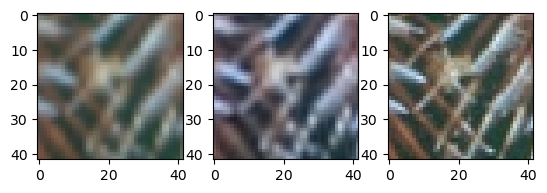

In [117]:

#INPUT IMAGE
plt.subplot(1,3,1)
plt.imshow(img)

# RESULT
plt.subplot(1,3,2)
plt.imshow(result)

#GROUNDTRUTH IMG
plt.subplot(1,3,3)
plt.imshow(label)


In [55]:
from torchvision.utils import make_grid

In [120]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 42, 42)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[20:28], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


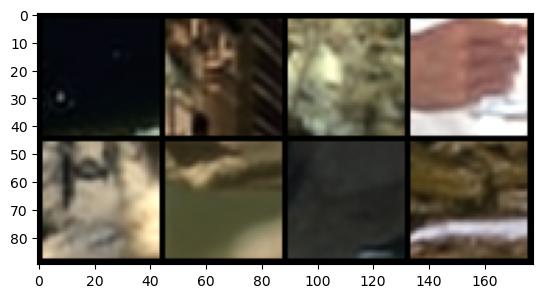

In [121]:
 show_tensor_images(results,num_images=8)

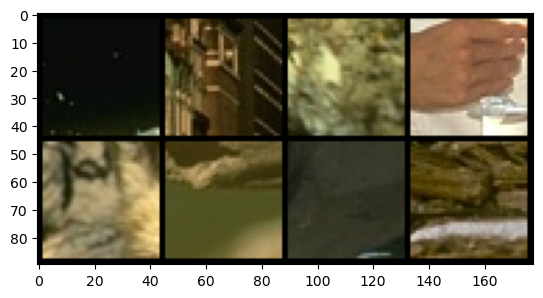

In [122]:
show_tensor_images(labels,num_images=8)

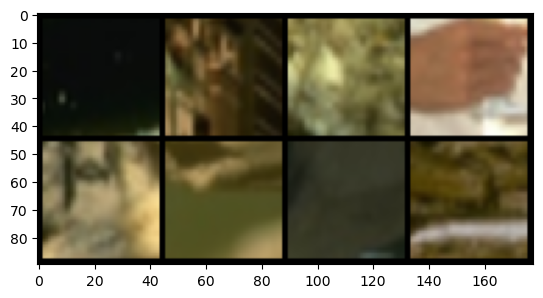

In [123]:
show_tensor_images(images,num_images=8)